## Makemore pt.2 - building a language model to generate English names
This notebook uses MLP (multi-layer perceptrons). It implements the architecture from [2003 paper "A Neural Probabilistic Language Model"](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

![img](./network_architecture.png)

What we want to achieve is to feed more context into the model - so that it's able to do the predictions on more than just a previous character.
The problem with previous statistical "counting" approach is that it quickly explodes - e.g. if we have 27 characters, context of 3 previous characters becomes 27**3. For increasing context, number of paramters grows exponentially. In the previous example each of the neurons was fully connected to the input, so each neuron would have 27\*\*3 weights.

The idea in this paper is to introduce a **embedding space** - association of characters into N dimensional feature vector space. This way we can "cluster" character sequences (or - words in the orignal paper) together.

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [2]:
words = open('./names.txt').read().splitlines()
print(f'{len(words)} words in the training set')

32033 words in the training set


In [3]:
# build mappings from chars to integers
space = set([char for word in words for char in list(word)])
stoi = {ch : i+1 for i, ch in enumerate(sorted(space))}
stoi['.'] = 0
itos = {i : ch for ch, i in stoi.items()}

In [4]:
# build the dataset
def bulid_dataset(input, context_size=3, debug=False):
    x, y = [], []
    for word in input:
        if debug: print(f'word: {word}')
        context = [stoi['.']] * context_size
        for ch in list(word) + ['.']:
            idx = stoi[ch]
            x.append(context)
            y.append(idx)
            if debug: print(''.join([itos[c] for c in context]) + " -> " + itos[idx])
            context = context[1:] + [idx]
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y

context_size = 3 # context length - how many characters the model will take to predict the next one
x, y = bulid_dataset(words[:3], context_size=context_size, debug=True)
print(f'x and y shapes: {x.shape}, {y.shape}')

word: emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
word: olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
word: ava
... -> a
..a -> v
.av -> a
ava -> .
x and y shapes: torch.Size([16, 3]), torch.Size([16])


In [5]:
# Embedding matrix - 2D space for 27 characters
C = torch.randn((27, 2))

# Those two are equivalent. This means that C lookup (embedding) might as well be a network layer - encoder in 
# the diagram from the research paper.
mul = F.one_hot(torch.tensor(5), num_classes=27).float() @ C
print(f'C[5] is {C[5]}, one-hot encoded "5" multiplied with C is also {mul}')

C[5] is tensor([-2.0308, -0.0208]), one-hot encoded "5" multiplied with C is also tensor([-2.0308, -0.0208])


In [6]:
print(f'C.shape: {C.shape}, x.shape: {x.shape}')
emb = C[x] # Pytorch magic - this expression interprets each item of x as row address in C. So if x[0][1] == 2 ('b'), then result R[0][1] = C[2]
print(f'x[0]={x[3]}, C[x][0]={C[x][3]}')
print(f'Resulting R.shape:{emb.shape}')

emb.shape # Resulting embedding for each of 3 chars of context in each x example has 2D vector value from C table.

C.shape: torch.Size([27, 2]), x.shape: torch.Size([16, 3])
x[0]=tensor([ 5, 13, 13]), C[x][0]=tensor([[-2.0308, -0.0208],
        [-0.3036,  0.0603],
        [-0.3036,  0.0603]])
Resulting R.shape:torch.Size([16, 3, 2])


torch.Size([16, 3, 2])

In [7]:
# Hidden layer
W1 = torch.randn((6, 100)) # 3x2 inputs (3 context chars each in 2D embeddings)
b1 = torch.randn(100)

In [8]:
# Our neurons have 6 inputs each but our training set is N examples x 3 chars of context x 2 vector embedding values. We need to reshape
# it so that it's a list of N x 6 examples.

# Inefficient way
embeddings = torch.cat(torch.unbind(emb, 1), 1)

# Efficient way
embeddings = emb.view(-1, 6)
print(f'{embeddings.shape=}')


embeddings.shape=torch.Size([16, 6])


## Broadcasting rules in Pytroch
1. Align shapes by padding lower-dimensional tensor with ones.
2. Dimensions are compatible if their sizes are equal or one of them is 1.
3. Output shape is determined by taking the maximum size along each dimension.
4. Tensors with size 1 in a dimension are expanded to match the corresponding size in the other tensor.

In [9]:
A = torch.tensor([[1,2,3],[4,5,6]])
B = torch.tensor([1,2,1])
# Shapes: 2x3, 3
# 1) Aligning the dimensions gives 2x3 and 1x3
# 2) Check
# 3) Out: 2x3
# 4) The 1,2,1 row gets copied over vertically and added element-wise
print(f'{A.shape=},{B.shape=}')
A + B

A.shape=torch.Size([2, 3]),B.shape=torch.Size([3])


tensor([[2, 4, 4],
        [5, 7, 7]])

In [32]:
g = torch.Generator().manual_seed(2147483647)
# Putting it all back together
x, y = bulid_dataset(words, context_size)
# Parameters
C = torch.randn((27, 2), generator=g) # 2D character embeddings
W1 = torch.randn((context_size*2, 100), generator=g) # Hidden layer - 100 neurons with 6 inputs (3 chars x 2 emb vector values), for block_size = 3
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g) # Fully connected out layer - 100 inputs, 27 neurons
b2 = torch.randn(27, generator=g)
paramters = [C, W1, b1, W2, b2]
for p in paramters: 
    p.requires_grad = True

In [28]:
def train(iters=10):
    for _ in range(iters):
        # Foward through embeddings lookup
        embeddings = C[x] # N x block_size x 2
        # unbind the 2nd dimension of the embedding matrix - list 2D vectors coords one by one in each input example
        inputs = embeddings.view(-1, 2*context_size) 

        # Foward through the first layer
        # Multiplying N x 6 (3 characters in 2D embeddings) matrix with 6 x 100 NN layer (100 neurons with 6 inputs each)

        hidden_layer = torch.tanh(inputs @ W1 + b1)
        # Forward through the second layer
        out_layer = hidden_layer @ W2 + b2

        # Calculate the loss
        # This under the hood does softmax on layer output and calculated negative log likelihood for the predicted prob of actual output from the training set
        # It's better to use it - safer numerically, optimized for forward and backward etc.
        loss = F.cross_entropy(out_layer, y)
        print(f'loss={loss.item()}')

        # Backward
        for p in paramters: 
            p.grad = None
        loss.backward()

        # Update
        step = -0.1
        for p in paramters:
            p.data += torch.tensor(step) * p.grad

train(10)

loss=19.505226135253906
loss=17.084484100341797
loss=15.776531219482422
loss=14.833340644836426
loss=14.002605438232422
loss=13.253264427185059
loss=12.57991886138916
loss=11.983102798461914
loss=11.47049331665039
loss=11.05185604095459


## Cross entropy
Cross-entropy is a measure of the difference between two probability distributions. It's often used as a loss function to train classifiers by minimizing the divergence between predicted probabilities and true class labels.
Under the hood, it is a softmax (interpret the output of a NN as probability distribution) + NLL (get a loss function on the probability assigned to the actual label of the data)

In [12]:
# Those lines are equivalent to F.cross_entropy()
# Softmax
out_layer = torch.randn(x.shape[0], 27)
exp = out_layer.exp()
prob = exp / exp.sum(1, keepdim=True)
y_probs = prob[np.arange(x.shape[0]), y]
# NLL
loss_manual = -y_probs.log().mean()


## Tweaking the training
### Technique \#1 - minibatching
Instead of running the forward/backward on all the trainig set, just sample it.

In [33]:
def train_minibatches(iters=10):
    for i in range(iters):
        # forward
        batch_idx = torch.randint(0, x.shape[0], (32,), generator=g) # randomly select 32 elements from training set
        x_batch = x[batch_idx]
        embeddings = C[x_batch]
        hidden_layer = torch.tanh(embeddings.view(-1,6) @ W1 + b1)
        out_layer = hidden_layer @ W2 + b2
        # loss
        loss = F.cross_entropy(out_layer, y[batch_idx])
        if i == 0 or (i+1) % 1000 == 0: print(f'{i+1}/{iters}, loss={loss.item()}')
        # backward
        for p in paramters:
            p.grad = None
        loss.backward()
        for p in paramters:
            p.data += torch.tensor(-0.01)*p.grad

train_minibatches(10000)


1/10000, loss=19.77227210998535
1000/10000, loss=3.724982976913452
2000/10000, loss=3.5079426765441895
3000/10000, loss=2.533734083175659
4000/10000, loss=2.5296764373779297
5000/10000, loss=2.726818561553955
6000/10000, loss=2.743476152420044
7000/10000, loss=2.9574029445648193
8000/10000, loss=3.147177219390869
9000/10000, loss=3.1089730262756348
10000/10000, loss=2.11515212059021


### Technique \#2 - finding the right loss

Trying out different losses and visualizing the plot.

In [25]:
lr_i=[]
loss_i=[]
def train_minibatches_varying_loss(iters=10):
    # Candidate learning rates
    exponents = torch.linspace(-3, 0, iters)
    learning_rates = 10**exponents

    for i in range(iters):
        # forward
        batch_idx = torch.randint(0, x.shape[0], (32,), generator=g) # randomly select 32 elements from training set
        x_batch = x[batch_idx]
        embeddings = C[x_batch]
        hidden_layer = torch.tanh(embeddings.view(-1,6) @ W1 + b1)
        out_layer = hidden_layer @ W2 + b2
        # loss
        loss = F.cross_entropy(out_layer, y[batch_idx])
        lr_i.append(exponents[i].item())
        loss_i.append(loss.item())
        # backward
        for p in paramters:
            p.grad = None
        loss.backward()
        for p in paramters:
            #p.data += torch.tensor(-0.001)*p.grad
            p.data += torch.tensor(-learning_rates[i])*p.grad

def get_loss_full_dataset():
    inputs = C[x].view(-1, 6)
    # forward
    hidden = torch.tanh(inputs @ W1 + b1)
    out_layer = hidden @ W2 + b2
    loss = F.cross_entropy(out_layer, y)
    print(f'loss={loss.item()}')

train_minibatches_varying_loss(10000)
get_loss_full_dataset()


C:\Users\oskip\AppData\Local\Temp\ipykernel_12752\3847019492.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p.data += torch.tensor(-learning_rates[i])*p.grad


loss=3.2548441886901855


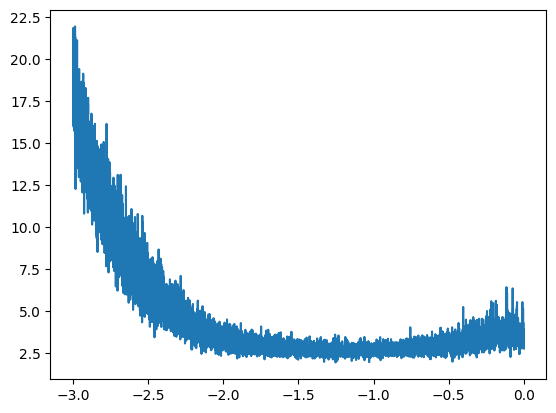

In [26]:
plt.plot(lr_i, loss_i)

From the plot above, we can see that 10**-1 is a good learning rate - learning rate above it makes the loss increase.

In [16]:
## Final training playground, prepared in more civilized manner
from dataclasses import dataclass

# Putting the parametrs back together again
g = torch.Generator().manual_seed(2147483647)
@dataclass
class HyperParameters:
    context_size: int = 3 # How many characters of context should NN get to make a prediction?
    embedding_dims: int = 5 # How many dimensions embedding vector have?
    hidden_layer_size: int = 250 # How many neurons in the hidden layer?

class Parameters:
    def __init__(self, g: torch.Generator, hyper_params: HyperParameters):
        hidden_layer_inputs = hyper_params.context_size * hyper_params.embedding_dims
        self.C = torch.randn((27, hyper_params.embedding_dims), generator=g, requires_grad=True)
        self.W1 = torch.randn((hidden_layer_inputs, hyper_params.hidden_layer_size), generator=g, requires_grad=True) # hidden layer weigths
        self.b1 = torch.randn((hyper_params.hidden_layer_size), generator=g, requires_grad=True) # hidden layer biases
        self.W2 = torch.randn((hyper_params.hidden_layer_size, 27), generator=g, requires_grad=True) # out layer weigths
        self.b2 = torch.randn((27), generator=g, requires_grad=True) # out layer biases
    
    def all(self):
        return [self.C, self.W1, self.b1, self.W2, self.b2]
    
    def zero_grad(self):
        for param in self.all():
            param.grad = None
    
    def update(self, learning_rate):
        for param in self.all():
            param.data += -learning_rate * param.grad

## Technique \#3 - split the training data
Training split, dev/validation split, test split

80%,10%,10%

### When do we overfit? When do we underfit?
Underfitting usually means that we get similar losses for validation set and training set. Once the loss for training set is significantly larger than for validation set, we might be overfitting.

In [17]:
hyper_params = HyperParameters(context_size=4, embedding_dims=16, hidden_layer_size=512)
params = Parameters(g, hyper_params)

print(f'{hyper_params=}')
print(f'params sizes={[param.shape for param in params.all()]}')

hyper_params=HyperParameters(context_size=4, embedding_dims=16, hidden_layer_size=512)
params sizes=[torch.Size([27, 16]), torch.Size([64, 512]), torch.Size([512]), torch.Size([512, 27]), torch.Size([27])]


In [18]:
import random
random.shuffle(words)
i_train = int(0.8 * len(words))
i_val = int(0.9 * len(words))
x_train, y_train = bulid_dataset(words[:i_train], context_size=hyper_params.context_size)
x_val, y_val = bulid_dataset(words[i_train:i_val], context_size=hyper_params.context_size)
x_test, y_test = bulid_dataset(words[i_val:], context_size=hyper_params.context_size)

iteration 10000, loss:5.614504814147949
iteration 20000, loss:3.8663485050201416
iteration 30000, loss:2.823031425476074
iteration 40000, loss:2.5326180458068848
iteration 50000, loss:2.9662351608276367
iteration 60000, loss:2.2912585735321045
iteration 70000, loss:2.604546546936035
iteration 80000, loss:1.9322073459625244
iteration 90000, loss:2.2138314247131348
iteration 100000, loss:2.0195164680480957
iteration 110000, loss:1.942169427871704
iteration 120000, loss:2.102998733520508
iteration 130000, loss:2.0979514122009277
iteration 140000, loss:2.4411046504974365
iteration 150000, loss:2.343611240386963
iteration 160000, loss:1.9222575426101685
iteration 170000, loss:2.3574917316436768
iteration 180000, loss:2.2075936794281006
iteration 190000, loss:2.287083864212036
iteration 200000, loss:2.231369972229004
iteration 210000, loss:2.354063034057617
iteration 220000, loss:2.380524158477783
iteration 230000, loss:2.0769686698913574
iteration 240000, loss:2.1517324447631836
iteration 2

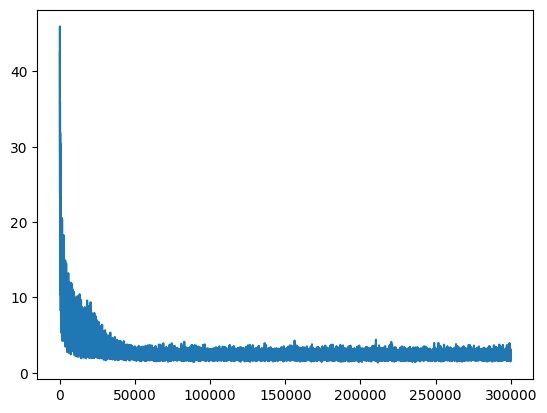

In [19]:
def get_loss(x_data, y_data, params, hyper_params):
    # Forward
    input_size = hyper_params.context_size * hyper_params.embedding_dims
    embeddings = params.C[x_data].view((-1, input_size))
    hidden = torch.tanh(embeddings @ params.W1 + params.b1)
    out = hidden @ params.W2 + params.b2
    # Calculate loss
    return F.cross_entropy(out, y_data)

def get_learning_rate(i):
    return 0.1 if i < 50000 else 0.01 if i < 100000 else 0.001

def train_final(iters: int, params: Parameters, hyper_params: HyperParameters, batch_size: int = 32):
    plot_data = torch.zeros((iters, 2))
    for i in range(iters):
        # Prepare batch
        batch_i = torch.randint(0, x_train.shape[0], (batch_size,))
        x_batch = x_train[batch_i]
        y_batch = y_train[batch_i]
        loss = get_loss(x_batch, y_batch, params, hyper_params)
        if (i+1) % 10000 == 0: print(f'iteration {i+1}/{iters}, loss:{loss.item()}')
        plot_data[i] = torch.tensor([i, loss.item()])
        params.zero_grad()
        # Backward
        loss.backward()
        # Update
        params.update(get_learning_rate(i))
    return plot_data


plot_data = train_final(300000, params=params, hyper_params=hyper_params, batch_size=32)
plt.plot(plot_data[:, 0], plot_data[:, 1])

loss_x_val = get_loss(x_val, y_val, params, hyper_params)
print(f'loss for validation set={loss_x_val.item()}')


In [35]:
def sample_network(iters: int, params: Parameters, hyper_params: HyperParameters):
    words = []
    for _ in range(iters):
        context = [stoi['.']] * hyper_params.context_size
        word = ''
        while True:
            # Forward
            embeddings = params.C[torch.tensor([context])]
            hidden = torch.tanh(embeddings.view(1, -1) @ params.W1 + params.b1)
            out = hidden @ params.W2 + params.b2
            probs = torch.softmax(out, dim=1)
            # Sample with distribution from probs
            sampled_idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
            if sampled_idx == 0: break
            # Move the context window
            context = context[1:] + [sampled_idx]
            word += itos[int(sampled_idx)]
        words.append(word)
    return words


samples = sample_network(10, params, hyper_params)
print(samples)

['salabia', 'yani', 'cniwa', 'katda', 'riza', 'reerlen', 'genovey', 'netitolasa', 'rurona', 'redlreelen']
